In [1]:
from DataParser import DataParser
import numpy as np
import scipy.sparse as sps
from sklearn.model_selection import KFold

from Data_manager.split_functions.split_train_validation_random_holdout import \
split_train_in_two_percentage_global_sample

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from SimpleEvaluator import evaluator
from Base.Evaluation.Evaluator import EvaluatorHoldout


In [2]:
from Base.NonPersonalizedRecommender import TopPop, Random
from Hybrid.HybridCombinationSearchCV import HybridCombinationMergedSearchCV, HybridCombinationSearchCV2
from KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from KNN.UserKNNCFRecommender import UserKNNCFRecommender
from KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from KNN.SpecialItemKNNCBFRecommender import SpecialItemKNNCBFRecommender
from MatrixFactorization.IALSRecommender import IALSRecommender
from SLIM_BPR.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from SLIM_ElasticNet.SLIMElasticNetRecommender import SLIMElasticNetRecommender
from SLIM_ElasticNet.SSLIM_ElasticNet import SSLIMElasticNet
from GraphBased.P3alphaRecommender import P3alphaRecommender
from GraphBased.RP3betaRecommender import RP3betaRecommender
from MatrixFactorization.Cython.MatrixFactorization_Cython import MatrixFactorization_BPR_Cython, MatrixFactorization_FunkSVD_Cython
from MatrixFactorization.PureSVDRecommender import PureSVDRecommender, PureSVDItemRecommender
from MatrixFactorization.NMFRecommender import NMFRecommender
from KNN.ItemKNN_CBF_CF import ItemKNN_CBF_CF
from KNN.UserKNNICF import UserKNNICF
from KNN.ItemKNNICF import ItemKNNICF
from GraphBased.RP3betaICM import RP3betaICM
from GraphBased.P3alphaICM import P3alphaICM

In [3]:
seed = 1666
parser = DataParser()

URM_all = parser.get_URM_all()
ICM_all = parser.get_ICM_all()

#URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage=0.85, seed=seed)

**single rec here**

In [4]:
rp3b = (RP3betaRecommender, {'topK': 926, 'alpha': 0.4300109351916609, 'beta': 0.01807360750913967, 'normalize_similarity': False})
p3a = (P3alphaRecommender, {'topK': 575, 'alpha': 0.48009885897470206, 'normalize_similarity': False})
icf = (ItemKNNCFRecommender, {'topK': 1000, 'shrink': 1000, 'similarity': 'cosine', 'normalize': True, 'feature_weighting': 'TF-IDF'})
ucf = (UserKNNCFRecommender, {'topK': 163, 'shrink': 846, 'similarity': 'cosine', 'normalize': True, 'feature_weighting': 'TF-IDF'})
icb = (ItemKNNCBFRecommender, {'topK': 164, 'shrink': 8, 'similarity': 'jaccard', 'normalize': True})
sbpr = (SLIM_BPR_Cython, {'topK': 1000, 'epochs': 130, 'symmetric': False, 'sgd_mode': 'adam', 'lambda_i': 1e-05, 'lambda_j': 1e-05, 'learning_rate': 0.0001})
icfcb = (ItemKNN_CBF_CF, {'topK': 1000, 'shrink': 1000, 'similarity': 'asymmetric', 'normalize': True, 'asymmetric_alpha': 0.241892724784089, 'feature_weighting': 'TF-IDF', 'icm_weight': 1.0})
sslim = (SSLIMElasticNet, {'beta': 0.567288665094892, 'topK': 1000, 'l1_ratio': 1e-05, 'alpha': 0.001})
psvd = (PureSVDRecommender, {'num_factors': 350})
ials = (IALSRecommender, {'num_factors': 126, 'epochs': 15, 'confidence_scaling': 'log', 'alpha': 12.147774561179066, 'epsilon': 0.011140000925581263, 'reg': 0.00039864851116724637})
icbsup = (SpecialItemKNNCBFRecommender, {'topK': 1000, 'shrink': 1000, 'similarity': 'cosine', 'normalize': True, 'feature_weighting': 'BM25'})
icmrp3b = (RP3betaICM, {'topK': 966, 'alpha': 0.37390944791085495, 'beta': 0.22865236967996966, 'normalize_similarity': False, 'icm_weight': 0.17241502697287484})
icmp3a = (P3alphaICM, {'topK': 1000, 'alpha': 0.44245956902357186, 'normalize_similarity': False, 'icm_weight': 0.0})
icmicf = (ItemKNNICF, {'topK': 938, 'shrink': 985, 'similarity': 'asymmetric', 'normalize': True, 'icm_weight': 0.9755193235505681, 'asymmetric_alpha': 0.0519842599512146, 'feature_weighting': 'TF-IDF'})

In [5]:
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=seed)

URM_list = []
URM_test_list = []
evaluator_list = []

shape = URM_all.shape
indptr = URM_all.indptr
indices = URM_all.indices
data = URM_all.data

for train_index, test_index in kf.split(data):
    data_train = np.ones(data.shape)
    data_test = np.ones(data.shape)
    data_train[test_index] = 0
    data_test[train_index] = 0
    kf_train = sps.csr_matrix((data_train, indices, indptr), shape=shape).copy()
    kf_test = sps.csr_matrix((data_test, indices, indptr), shape=shape).copy()
    kf_train.eliminate_zeros()
    kf_test.eliminate_zeros()
    URM_list.append(kf_train)
    URM_test_list.append(kf_test)
    evaluator_list.append(EvaluatorHoldout(kf_test, cutoff_list=[10]))

In [6]:
#0: label, 1: type, 2: list, 3:params
recommenders = [
    #single
    ('icb', 'single', icb, {}),
    ('icbsup', 'single', icbsup, {}),
    ('rp3b', 'single', rp3b, {}),
    ('p3a', 'single', p3a, {}),
    ('icf', 'single', icf, {}),
    ('ucf', 'single', ucf, {}),
    ('sbpr', 'single', sbpr, {}),
    ('sslim', 'single', sslim, {}),
    ('psvd', 'single', psvd, {}),
    ('ials', 'single', ials, {}),
    ('icfcb', 'single', icfcb, {}),
    ('icmrp3b', 'single', icmrp3b, {}),
    ('icmp3a', 'single', icmp3a, {}),
    ('icmicf', 'single', icmicf, {}),
    #linear
    ('icbsup, icfcb, ials', 'linear', [icbsup, icfcb, ials], {'a': 0.36058590020108144, 'b': 1.0, 'c': 0.48626010859242946, 'normalize': False}),
('icbsup, icfcb, p3a', 'linear', [icbsup, icfcb, p3a], {'a': 0.993188337424128, 'b': 0.9909175139221994, 'c': 0.7815444492201006, 'normalize': False}),
('icbsup, p3a, ials', 'linear', [icbsup, p3a, ials], {'a': 1.0, 'b': 0.7661797896811, 'c': 0.3737948087825911, 'normalize': False}),
('icbsup, rp3b, ials', 'linear', [icbsup, rp3b, ials], {'a': 0.5477316616284982, 'b': 0.27917456603570484, 'c': 0.424728075817424, 'normalize': False}),
('icbsup, icfcb, rp3b', 'linear', [icbsup, icfcb, rp3b], {'a': 0.2901802313422713, 'b': 0.4392120921456557, 'c': 0.16625489563936016, 'normalize': False}),
('icb, icfcb, p3a', 'linear', [icb, icfcb, p3a], {'a': 0.39988908366603393, 'b': 0.7467067794473331, 'c': 0.2068190996377532, 'normalize': False}),
('icbsup, ucf, p3a', 'linear', [icbsup, ucf, p3a], {'a': 0.9662016322698685, 'b': 0.4963111377096092, 'c': 0.6874259637686088, 'normalize': False}),
('icb, icfcb, ials', 'linear', [icb, icfcb, ials], {'a': 0.3598307369255694, 'b': 0.9238742605453991, 'c': 0.09362526992787447, 'normalize': False}),
('icbsup, p3a, sslim', 'linear', [icbsup, p3a, sslim], {'a': 0.11340363717192684, 'b': 0.07221362174970904, 'c': 0.7644867129062151, 'normalize': False}),
('icbsup, rp3b, sbpr', 'linear', [icbsup, rp3b, sbpr], {'a': 0.6351784979513733, 'b': 0.4227964938023694, 'c': 0.96815170415434, 'normalize': False}),
('icbsup, p3a, sbpr', 'linear', [icbsup, p3a, sbpr], {'a': 0.8495173762195323, 'b': 0.7916707351347642, 'c': 0.0, 'normalize': False}),
('icbsup, sbpr, sslim', 'linear', [icbsup, sbpr, sslim], {'a': 1.0, 'b': 0.548724319649282, 'c': 1.0, 'normalize': True}),
('icbsup, rp3b, sslim', 'linear', [icbsup, rp3b, sslim], {'a': 0.9943636298152313, 'b': 0.6338212977896964, 'c': 0.9064091710184868, 'normalize': False}),
('icb, icfcb, sbpr', 'linear', [icb, icfcb, sbpr], {'a': 0.36471733011095414, 'b': 1.0, 'c': 1.0, 'normalize': False}),
('icbsup, icfcb, sbpr', 'linear', [icbsup, icfcb, sbpr], {'a': 0.16721122903353033, 'b': 0.6078522485010392, 'c': 1.0, 'normalize': False}),
('icb, icfcb, ucf', 'linear', [icb, icfcb, ucf], {'a': 0.2127784681579103, 'b': 0.60649347517527, 'c': 0.1328508812429561, 'normalize': False}),
('icbsup, icf, rp3b', 'linear', [icbsup, icf, rp3b], {'a': 0.974238032123889, 'b': 0.05681121439278215, 'c': 0.7588862294834752, 'normalize': False}),
('icbsup, icf, p3a', 'linear', [icbsup, icf, p3a], {'a': 1.0, 'b': 0.0, 'c': 1.0, 'normalize': False}),
('icbsup, ucf, rp3b', 'linear', [icbsup, ucf, rp3b], {'a': 0.8978309114164305, 'b': 0.4854872045282991, 'c': 0.5843535501206276, 'normalize': False}),
('icbsup, rp3b, p3a', 'linear', [icbsup, rp3b, p3a], {'a': 0.8490806214717617, 'b': 0.22519798480808623, 'c': 0.5961181908448233, 'normalize': False}),
('icbsup, sslim, ials', 'linear', [icbsup, sslim, ials], {'a': 0.47843310889046786, 'b': 0.4230302033543626, 'c': 0.04939098259646259, 'normalize': True}),
('icbsup, icfcb, ucf', 'linear', [icbsup, icfcb, ucf], {'a': 0.5406791705129667, 'b': 1.0, 'c': 1.0, 'normalize': False}),
('icbsup, ucf, ials', 'linear', [icbsup, ucf, ials], {'a': 0.7047934527842207, 'b': 0.9177721741919709, 'c': 0.5361610061271527, 'normalize': False}),
('icb, icfcb, rp3b', 'linear', [icb, icfcb, rp3b], {'a': 0.39988908366603393, 'b': 0.7467067794473331, 'c': 0.2068190996377532, 'normalize': False}),
('icbsup, icf, ials', 'linear', [icbsup, icf, ials], {'a': 0.64097426871921, 'b': 1.0, 'c': 0.5735079033664336, 'normalize': False}),
    #merged
    ('icbsup, icfcb, p3a', 'merged', [icbsup, icfcb, p3a], {'alpha': 0.581116263967674, 'l1_ratio': 0.5598903069887389, 'topK': 1000, 'normalize': True}),
('icb, icfcb, sbpr', 'merged', [icb, icfcb, sbpr], {'alpha': 0.6829163194586242, 'l1_ratio': 0.386516642359119, 'topK': 1000, 'normalize': True}),
('icbsup, icfcb, rp3b', 'merged', [icbsup, icfcb, rp3b], {'alpha': 0.7269115930024891, 'l1_ratio': 0.6051868432813969, 'topK': 807, 'normalize': False}),
('icb, icfcb, p3a', 'merged', [icb, icfcb, p3a], {'alpha': 0.7097149976708894, 'l1_ratio': 0.4253431147789698, 'topK': 683, 'normalize': True}),
('icbsup, p3a, sslim', 'merged', [icbsup, p3a, sslim], {'alpha': 0.6509731450181614, 'l1_ratio': 0.5325849264151943, 'topK': 736, 'normalize': True}),
('icbsup, rp3b, sslim', 'merged', [icbsup, rp3b, sslim], {'alpha': 0.16451383666897593, 'l1_ratio': 0.7280753668239933, 'topK': 622, 'normalize': False}),
('icbsup, sbpr, sslim', 'merged', [icbsup, sbpr, sslim], {'alpha': 0.535827782580078, 'l1_ratio': 0.42823755538774455, 'topK': 228, 'normalize': True}),
('icbsup, p3a, sbpr', 'merged', [icbsup, p3a, sbpr], {'alpha': 0.48791974774529073, 'l1_ratio': 0.5476114683349933, 'topK': 749, 'normalize': False}),
('icbsup, p3a, rp3b', 'merged', [icbsup, p3a, rp3b], {'alpha': 1.0, 'l1_ratio': 0.3749359476595637, 'topK': 1000, 'normalize': True}),
('icbsup, icf, rp3b', 'merged', [icbsup, icf, rp3b], {'alpha': 0.5086347515387531, 'l1_ratio': 0.8318853016648462, 'topK': 1000, 'normalize': True}),
('icbsup, rp3b, sbpr', 'merged', [icbsup, rp3b, sbpr], {'alpha': 0.7702171365467229, 'l1_ratio': 0.4846943139192311, 'topK': 985, 'normalize': True}),
('icbsup, icf, p3a', 'merged', [icbsup, icf, p3a], {'alpha': 0.5334947443510734, 'l1_ratio': 0.7670738264844964, 'topK': 984, 'normalize': True}),
('icb, sbpr, sslim', 'merged', [icb, sbpr, sslim], {'alpha': 0.5191303017757435, 'l1_ratio': 0.5397979031860276, 'topK': 1000, 'normalize': True}),
('icbsup, icf, sbpr', 'merged', [icbsup, icf, sbpr], {'alpha': 0.2956440034792403, 'l1_ratio': 0.29893177702984014, 'topK': 1000, 'normalize': False}),
('icb, icfcb, rp3b', 'merged', [icb, icfcb, rp3b], {'alpha': 0.5837741870266273, 'l1_ratio': 0.537759713449255, 'topK': 840, 'normalize': True}),
('icb, icfcb, sslim', 'merged', [icb, icfcb, sslim], {'alpha': 0.5349175218474181, 'l1_ratio': 0.2576251556087315, 'topK': 1000, 'normalize': False}),
('icbsup, icfcb, sbpr', 'merged', [icbsup, icfcb, sbpr], {'alpha': 0.42057870266300357, 'l1_ratio': 0.09026142584874454, 'topK': 274, 'normalize': False}),
    #ICM
('icbsup, icmrp3b, ials', 'linear', [icbsup, icmrp3b, ials], {'a': 0.07420769786908767, 'b': 0.584898150644118, 'c': 0.3803601317012001, 'normalize': False}),
('icfcb, icmrp3b, ials', 'linear', [icfcb, icmrp3b, ials], {'a': 0.017067361148354724, 'b': 0.7274548621001062, 'c': 0.27353984257960623, 'normalize': False}),
('icbsup, icmicf, ials', 'linear', [icbsup, icmicf, ials], {'a': 0.2175917919037978, 'b': 0.6285149081988548, 'c': 0.22445565190383093, 'normalize': False}),
('icbsup, icmp3a, ials', 'linear', [icbsup, icmp3a, ials], {'a': 0.8811106278521803, 'b': 0.995044128917882, 'c': 0.9923604723125242, 'normalize': False}),
('icbsup, icmrp3b, ucf', 'linear', [icbsup, icmrp3b, ucf], {'a': 0.14083972616859766, 'b': 0.9609833488534627, 'c': 0.9238124422437706, 'normalize': True}),
('icbsup, icmrp3b, sbpr', 'linear', [icbsup, icmrp3b, sbpr], {'a': 0.0, 'b': 0.3998226632343897, 'c': 1.0, 'normalize': False}),
('icfcb, icmrp3b, sbpr', 'linear', [icfcb, icmrp3b, sbpr], {'a': 0.1467949178842375, 'b': 0.1584715250096637, 'c': 0.27857847703674227, 'normalize': False}),
('icfcb, icmrp3b, ucf', 'linear', [icfcb, icmrp3b, ucf], {'a': 0.19138735162037318, 'b': 0.9133150283192922, 'c': 0.2553396192583934, 'normalize': False}),
('icbsup, icmicf, sbpr', 'linear', [icbsup, icmicf, sbpr], {'a': 0.013430155803415004, 'b': 0.035913204804579386, 'c': 0.011804061463974617, 'normalize': True}),
('icbsup, sslim, icmrp3b', 'linear', [icbsup, sslim, icmrp3b], {'a': 0.027002938776832026, 'b': 0.9978798359291955, 'c': 0.3520612477042648, 'normalize': False}),
('icfcb, sslim, icmrp3b', 'linear', [icfcb, sslim, icmrp3b], {'a': 0.010999497476339106, 'b': 0.08986011162154052, 'c': 0.9848282767910838, 'normalize': True}),
('icfcb, icmrp3b, icmicf', 'linear', [icfcb, icmrp3b, icmicf], {'a': 0.23450795360970716, 'b': 0.5437616634642125, 'c': 0.2446348132625526, 'normalize': False}),
('icbsup, icmrp3b, icmicf', 'linear', [icbsup, icmrp3b, icmicf], {'a': 0.04686143996764525, 'b': 0.7313406684376907, 'c': 0.5504751108336646, 'normalize': False}),
('icbsup, icfcb, icmrp3b', 'linear', [icbsup, icfcb, icmrp3b], {'a': 0.0013020767509568378, 'b': 0.03486336001893254, 'c': 0.042620973924971224, 'normalize': True}),
('icfcb, icmp3a, ials', 'linear', [icfcb, icmp3a, ials], {'a': 0.9548721885377981, 'b': 0.9669315576536804, 'c': 0.9759005809888212, 'normalize': False}),
('icbsup, icmicf, ucf', 'linear', [icbsup, icmicf, ucf], {'a': 0.49389969407771356, 'b': 1.0, 'c': 1.0, 'normalize': False}),
]

In [7]:
num_rec = len(recommenders)

In [8]:
f_ranges = [
    (0,4),
    (4,7),
    (7,13),
    (13,26),
    (26,-1)
]

MAP_per_group = []
cutoff = 10

for f_range in f_ranges:
    
    result_dict={}
    for k in range (num_rec):
        r = []
        for i in range (len(URM_list)):
            URM_test_group = parser.filter_URM_test_by_range(URM_list[i], URM_test_list[i], f_range)
            evaluator_test = EvaluatorHoldout(URM_test_group, cutoff_list=[cutoff])
            
            if recommenders[k][1] == 'single':
                rec = recommenders[k][2][0]
                try:
                    rec = rec(URM_list[i], ICM_all, verbose = False)
                except:
                    rec = rec(URM_list[i], verbose=False)
                try:
                    rec.load_model(f'stored_recommenders/seed_{str(seed)}_hybrid_search/{rec.RECOMMENDER_NAME}/', f'{str(seed)}_fold-{str(i)}')
                    print(f"{rec.RECOMMENDER_NAME} loaded. [seed={seed}, fold={i}]")
                except:
                    print(f"Fitting {rec.RECOMMENDER_NAME} ... [seed={seed}, fold={i}]")
                    rec.fit(**recommenders[k][2][1])
                    print(f"done.")
                    rec.save_model(f'stored_recommenders/seed_{str(seed)}_hybrid_search/{rec.RECOMMENDER_NAME}/', f'{str(seed)}_fold-{str(i)}')
            elif recommenders[k][1] == 'linear':
                rec = HybridCombinationSearchCV2(URM_list[i], ICM_all, recommenders[k][2], seed = seed, fold = i)
                rec.fit(**recommenders[k][3])
            elif recommenders[k][1] == 'merged':
                rec = HybridCombinationMergedSearchCV(URM_list[i], ICM_all, recommenders[k][2], seed = seed, fold = i)
                rec.fit(**recommenders[k][3])
            else:
                raise NameError

            results, _ = evaluator_test.evaluateRecommender(rec)
            r.append(results[cutoff]["MAP"])
        result_dict[k]=np.average(r)

    MAP_per_group.append(result_dict)

ItemKNNCBFRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1687 ( 100.00% ) in 0.97 sec. Users per second: 1734
ItemKNNCBFRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 0.91 sec. Users per second: 1796
ItemKNNCBFRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1700 ( 100.00% ) in 0.96 sec. Users per second: 1778
ItemKNNCBFRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 0.87 sec. Users per second: 1883
ItemKNNCBFRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1633 ( 100.00% ) in 0.88 sec. Users per second: 1856
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1687 ( 100.00% ) in 1.03 sec. Users per second: 1634
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 0.98 sec. Users per second: 1675
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1700 

S-SLIMElasticNet loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1687 ( 100.00% ) in 1.49 sec. Users per second: 1135
S-SLIMElasticNet loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 1.96 sec. Users per second: 839
S-SLIMElasticNet loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1700 ( 100.00% ) in 1.52 sec. Users per second: 1119
S-SLIMElasticNet loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 1.51 sec. Users per second: 1089
S-SLIMElasticNet loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1633 ( 100.00% ) in 1.43 sec. Users per second: 1141
PureSVDRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1687 ( 100.00% ) in 1.30 sec. Users per second: 1298
PureSVDRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 1.36 sec. Users per second: 1205
PureSVDRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1700 ( 100.00% ) in 1.45 sec. Users per 

IALSRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1687 ( 100.00% ) in 2.44 sec. Users per second: 691
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=1]
IALSRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 2.38 sec. Users per second: 689
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=2]
IALSRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1700 ( 100.00% ) in 2.54 sec. Users per second: 669
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded

RP3betaRecommender loaded. [seed=1666, fold=3]
IALSRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 2.34 sec. Users per second: 701
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
RP3betaRecommender loaded. [seed=1666, fold=4]
IALSRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1633 ( 100.00% ) in 2.33 sec. Users per second: 701
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=0]
RP3betaRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1687 ( 100.00% ) in 1.79 sec. Users per second: 943
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %

ItemKNNCBFRecommender loaded. [seed=1666, fold=1]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=1]
IALSRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 2.33 sec. Users per second: 703
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=2]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=2]
IALSRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1700 ( 100.00% ) in 2.43 sec. Users per second: 701
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=3]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=3]
IALSRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 2.32 sec. Users per second: 708
HybridCombinationSearchCV: URM Detected 77 (0.97 %) c

Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
P3alphaRecommender loaded. [seed=1666, fold=4]
SLIM_BPR_Recommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1633 ( 100.00% ) in 1.62 sec. Users per second: 1008
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
SLIM_BPR_Recommender loaded. [seed=1666, fold=0]
S-SLIMElasticNet loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1687 ( 100.00% ) in 2.44 sec. Users per second: 692
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
SLIM_BPR_Recommender loaded. [seed=1666, fold=1]
S-SLIMElasticNet loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 2.36 sec. Users per second: 695
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
H

Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=2]
SLIM_BPR_Recommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1700 ( 100.00% ) in 1.80 sec. Users per second: 943
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=3]
SLIM_BPR_Recommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 1.76 sec. Users per second: 930
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=4]
SLIM_BPR_Recommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1633 ( 100.00% ) in 1.70 sec. Users per second: 963
HybridCombinationSearchCV: URM Detecte

Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
UserKNNCFRecommender loaded. [seed=1666, fold=0]
RP3betaRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1687 ( 100.00% ) in 1.69 sec. Users per second: 997
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
UserKNNCFRecommender loaded. [seed=1666, fold=1]
RP3betaRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 1.69 sec. Users per second: 970
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
UserKNNCFRecommender loaded. [seed=1666, fold=2]
RP3betaRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1700 ( 100.00% ) in 1.73 sec. Users per second: 984
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users

Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=3]
UserKNNCFRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 1.72 sec. Users per second: 952
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=4]
UserKNNCFRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1633 ( 100.00% ) in 1.71 sec. Users per second: 953
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
UserKNNCFRecommender loaded. [seed=1666, fold=0]
IALSRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1687 ( 100.00% ) in 2.42 sec. Users per second: 697
HybridCombinationSearchCV: URM Detected 68 (0.86 

Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=1]
P3alphaRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 1.42 sec. Users per second: 1153
HybridCombinationMergedSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=2]
P3alphaRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1700 ( 100.00% ) in 1.56 sec. Users per second: 1088
HybridCombinationMergedSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=3]
P3alphaRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 1.58 sec. Users per second: 1039
HybridCombination

P3alphaRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 1.29 sec. Users per second: 1272
HybridCombinationMergedSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2398 (9.23 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=4]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=4]
P3alphaRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1633 ( 100.00% ) in 1.30 sec. Users per second: 1259
HybridCombinationMergedSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
P3alphaRecommender loaded. [seed=1666, fold=0]
S-SLIMElasticNet loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1687 ( 100.00% ) in 1.27 sec. Users per second: 1333
HybridCombinationMergedSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2439 (9.39 %) co

Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
P3alphaRecommender loaded. [seed=1666, fold=1]
SLIM_BPR_Recommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 1.50 sec. Users per second: 1095
HybridCombinationMergedSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
P3alphaRecommender loaded. [seed=1666, fold=2]
SLIM_BPR_Recommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1700 ( 100.00% ) in 1.47 sec. Users per second: 1157
HybridCombinationMergedSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
P3alphaRecommender loaded. [seed=1666, fold=3]
SLIM_BPR_Recommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 1.42 sec. Users per second: 1153
HybridCombinationMergedSearchCV: UR

HybridCombinationMergedSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
RP3betaRecommender loaded. [seed=1666, fold=4]
SLIM_BPR_Recommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1633 ( 100.00% ) in 1.78 sec. Users per second: 916
HybridCombinationMergedSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
ItemKNNCFRecommender loaded. [seed=1666, fold=0]
P3alphaRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1687 ( 100.00% ) in 1.44 sec. Users per second: 1174
HybridCombinationMergedSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
ItemKNNCFRecommender loaded. [seed=1666, fold=1]
P3alphaRecommender loa

ItemKNNCBFRecommender loaded. [seed=1666, fold=1]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=1]
RP3betaRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 1.31 sec. Users per second: 1250
HybridCombinationMergedSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2402 (9.25 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=2]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=2]
RP3betaRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1700 ( 100.00% ) in 1.36 sec. Users per second: 1251
HybridCombinationMergedSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2338 (9.00 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=3]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=3]
RP3betaRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 1.34 sec. Users per second: 1220
HybridCombination

HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
RP3betaICM loaded. [seed=1666, fold=4]
IALSRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1633 ( 100.00% ) in 2.24 sec. Users per second: 729
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=0]
RP3betaICM loaded. [seed=1666, fold=0]
IALSRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1687 ( 100.00% ) in 2.39 sec. Users per second: 704
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=1]
RP3betaICM loaded. [seed=1666, fold=1]
IALSRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1640 ( 100.00

Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
RP3betaICM loaded. [seed=1666, fold=2]
UserKNNCFRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1700 ( 100.00% ) in 1.84 sec. Users per second: 926
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
RP3betaICM loaded. [seed=1666, fold=3]
UserKNNCFRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 1.75 sec. Users per second: 935
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
RP3betaICM loaded. [seed=1666, fold=4]
UserKNNCFRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1633 ( 100.00% ) in 1.77 sec. Users per second: 920
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearc

ItemKNNICF loaded. [seed=1666, fold=0]
SLIM_BPR_Recommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1687 ( 100.00% ) in 1.82 sec. Users per second: 927
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
ItemKNNICF loaded. [seed=1666, fold=1]
SLIM_BPR_Recommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 1.74 sec. Users per second: 940
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
ItemKNNICF loaded. [seed=1666, fold=2]
SLIM_BPR_Recommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1700 ( 100.00% ) in 1.89 sec. Users per second: 901
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
Specia

HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=4]
RP3betaICM loaded. [seed=1666, fold=4]
ItemKNNICF loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1633 ( 100.00% ) in 1.77 sec. Users per second: 924
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
RP3betaICM loaded. [seed=1666, fold=0]
ItemKNNICF loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1687 ( 100.00% ) in 1.76 sec. Users per second: 958
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
RP3betaICM loaded. [seed=1666, fold=1]
ItemKNNICF loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 1.76 sec. Use

Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
ItemKNNICF loaded. [seed=1666, fold=2]
UserKNNCFRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1700 ( 100.00% ) in 1.72 sec. Users per second: 986
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
ItemKNNICF loaded. [seed=1666, fold=3]
UserKNNCFRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1640 ( 100.00% ) in 1.66 sec. Users per second: 986
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
ItemKNNICF loaded. [seed=1666, fold=4]
UserKNNCFRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1633 ( 100.00% ) in 1.69 sec. Users per second: 964
ItemKNNCBFRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1245 ( 1

SLIM_BPR_Recommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1245 ( 100.00% ) in 0.77 sec. Users per second: 1617
SLIM_BPR_Recommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1277 ( 100.00% ) in 0.79 sec. Users per second: 1618
SLIM_BPR_Recommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1274 ( 100.00% ) in 0.79 sec. Users per second: 1610
SLIM_BPR_Recommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 0.80 sec. Users per second: 1628
SLIM_BPR_Recommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 0.81 sec. Users per second: 1597
S-SLIMElasticNet loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1245 ( 100.00% ) in 1.20 sec. Users per second: 1039
S-SLIMElasticNet loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1277 ( 100.00% ) in 1.23 sec. Users per second: 1039
S-SLIMElasticNet loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1274 ( 100.00% ) in 1.23 

ItemKNNICF loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1277 ( 100.00% ) in 0.85 sec. Users per second: 1501
ItemKNNICF loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1274 ( 100.00% ) in 0.87 sec. Users per second: 1472
ItemKNNICF loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 0.88 sec. Users per second: 1466
ItemKNNICF loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 0.90 sec. Users per second: 1444
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=0]
IALSRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1245 ( 100.00% ) in 1.95 sec. Users per second: 640
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [

Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
RP3betaRecommender loaded. [seed=1666, fold=1]
IALSRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1277 ( 100.00% ) in 1.85 sec. Users per second: 692
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
RP3betaRecommender loaded. [seed=1666, fold=2]
IALSRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1274 ( 100.00% ) in 1.82 sec. Users per second: 702
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
RP3betaRecommender loaded. [seed=1666, fold=3]
IALSRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 1.85 sec. Users per second: 700
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombina

Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
UserKNNCFRecommender loaded. [seed=1666, fold=4]
P3alphaRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 1.45 sec. Users per second: 893
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=0]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=0]
IALSRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1245 ( 100.00% ) in 1.80 sec. Users per second: 693
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=1]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=1]
IALSRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1277 ( 100.00% ) in 1.90 sec. Users per second: 672
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold

Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
P3alphaRecommender loaded. [seed=1666, fold=2]
SLIM_BPR_Recommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1274 ( 100.00% ) in 1.46 sec. Users per second: 874
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
P3alphaRecommender loaded. [seed=1666, fold=3]
SLIM_BPR_Recommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 1.48 sec. Users per second: 874
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
P3alphaRecommender loaded. [seed=1666, fold=4]
SLIM_BPR_Recommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 1.49 sec. Users per second: 868
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users

Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=0]
SLIM_BPR_Recommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1245 ( 100.00% ) in 1.47 sec. Users per second: 849
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=1]
SLIM_BPR_Recommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1277 ( 100.00% ) in 1.51 sec. Users per second: 845
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=2]
SLIM_BPR_Recommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1274 ( 100.00% ) in 1.50 sec. Users per second: 852
HybridCombinationSearchCV: URM Detecte

Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
ItemKNNCFRecommender loaded. [seed=1666, fold=3]
P3alphaRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 1.47 sec. Users per second: 878
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
ItemKNNCFRecommender loaded. [seed=1666, fold=4]
P3alphaRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 1.46 sec. Users per second: 886
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
UserKNNCFRecommender loaded. [seed=1666, fold=0]
RP3betaRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1245 ( 100.00% ) in 1.37 sec. Users per second: 909
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users

Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=1]
UserKNNCFRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1277 ( 100.00% ) in 1.48 sec. Users per second: 865
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=2]
UserKNNCFRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1274 ( 100.00% ) in 1.52 sec. Users per second: 838
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=3]
UserKNNCFRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 1.57 sec. Users per second: 823
HybridCombinationSearchCV: URM Detecte

Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
ItemKNNCFRecommender loaded. [seed=1666, fold=4]
IALSRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 1.87 sec. Users per second: 694
HybridCombinationMergedSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=0]
P3alphaRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1245 ( 100.00% ) in 1.22 sec. Users per second: 1022
HybridCombinationMergedSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=1]
P3alphaRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1277 ( 100.00% ) in 1.23 sec. Users per second: 1035
HybridCombinationMergedSear

P3alphaRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1277 ( 100.00% ) in 1.11 sec. Users per second: 1151
HybridCombinationMergedSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2402 (9.25 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=2]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=2]
P3alphaRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1274 ( 100.00% ) in 1.16 sec. Users per second: 1102
HybridCombinationMergedSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2338 (9.00 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=3]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=3]
P3alphaRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 1.13 sec. Users per second: 1151
HybridCombinationMergedSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2398 (

Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
SLIM_BPR_Recommender loaded. [seed=1666, fold=4]
S-SLIMElasticNet loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 0.99 sec. Users per second: 1313
HybridCombinationMergedSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
P3alphaRecommender loaded. [seed=1666, fold=0]
SLIM_BPR_Recommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1245 ( 100.00% ) in 1.14 sec. Users per second: 1093
HybridCombinationMergedSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
P3alphaRecommender loaded. [seed=1666, fold=1]
SLIM_BPR_Recommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1277 ( 100.00% ) in 1.14 sec. Users per second: 1120
HybridCombinationMergedSearchCV: URM 

HybridCombinationMergedSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
RP3betaRecommender loaded. [seed=1666, fold=2]
SLIM_BPR_Recommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1274 ( 100.00% ) in 1.27 sec. Users per second: 1007
HybridCombinationMergedSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
RP3betaRecommender loaded. [seed=1666, fold=3]
SLIM_BPR_Recommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 1.27 sec. Users per second: 1023
HybridCombinationMergedSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
RP3betaRecommender loaded. [seed=1666, fold=4]
SLIM_BPR_Recommender lo

Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
ItemKNNCFRecommender loaded. [seed=1666, fold=4]
SLIM_BPR_Recommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 1.29 sec. Users per second: 1005
HybridCombinationMergedSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2381 (9.17 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=0]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=0]
RP3betaRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1245 ( 100.00% ) in 1.12 sec. Users per second: 1112
HybridCombinationMergedSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2439 (9.39 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=1]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=1]
RP3betaRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1277 ( 100.00% ) in 1.19 sec. Users per second: 1075
HybridCombinationMerg

EvaluatorHoldout: Processed 1277 ( 100.00% ) in 1.88 sec. Users per second: 680
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
RP3betaICM loaded. [seed=1666, fold=2]
IALSRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1274 ( 100.00% ) in 1.85 sec. Users per second: 690
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
RP3betaICM loaded. [seed=1666, fold=3]
IALSRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 1.94 sec. Users per second: 667
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
RP3betaICM loaded. [seed=1666, fold=4]
IALSRecommender

Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
RP3betaICM loaded. [seed=1666, fold=0]
UserKNNCFRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1245 ( 100.00% ) in 1.50 sec. Users per second: 828
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
RP3betaICM loaded. [seed=1666, fold=1]
UserKNNCFRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1277 ( 100.00% ) in 1.54 sec. Users per second: 831
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
RP3betaICM loaded. [seed=1666, fold=2]
UserKNNCFRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1274 ( 100.00% ) in 1.54 sec. Users per second: 826
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearc

RP3betaICM loaded. [seed=1666, fold=3]
UserKNNCFRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 1.45 sec. Users per second: 893
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=4]
RP3betaICM loaded. [seed=1666, fold=4]
UserKNNCFRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 1.43 sec. Users per second: 904
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
ItemKNNICF loaded. [seed=1666, fold=0]
SLIM_BPR_Recommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1245 ( 100.00% ) in 1.54 sec. Users per second: 811
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
S

HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=2]
RP3betaICM loaded. [seed=1666, fold=2]
ItemKNNICF loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1274 ( 100.00% ) in 1.52 sec. Users per second: 838
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=3]
RP3betaICM loaded. [seed=1666, fold=3]
ItemKNNICF loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 1.52 sec. Users per second: 852
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=4]
RP3betaICM loaded. [seed=1666, fold=4]
ItemKNNICF loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1295 ( 100.00% ) in 1.5

Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
ItemKNNICF loaded. [seed=1666, fold=0]
UserKNNCFRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1245 ( 100.00% ) in 1.47 sec. Users per second: 848
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
ItemKNNICF loaded. [seed=1666, fold=1]
UserKNNCFRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1277 ( 100.00% ) in 1.47 sec. Users per second: 869
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
ItemKNNICF loaded. [seed=1666, fold=2]
UserKNNCFRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1274 ( 100.00% ) in 1.50 sec. Users per second: 847
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearc

EvaluatorHoldout: Processed 1112 ( 100.00% ) in 0.69 sec. Users per second: 1608
UserKNNCFRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1155 ( 100.00% ) in 0.68 sec. Users per second: 1709
UserKNNCFRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1164 ( 100.00% ) in 0.72 sec. Users per second: 1611
UserKNNCFRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1127 ( 100.00% ) in 0.68 sec. Users per second: 1667
SLIM_BPR_Recommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1193 ( 100.00% ) in 0.80 sec. Users per second: 1497
SLIM_BPR_Recommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1112 ( 100.00% ) in 0.73 sec. Users per second: 1531
SLIM_BPR_Recommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1155 ( 100.00% ) in 0.93 sec. Users per second: 1248
SLIM_BPR_Recommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1164 ( 100.00% ) in 0.77 sec. Users per second: 1514
SLIM_BPR_

P3alphaICM loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1155 ( 100.00% ) in 0.86 sec. Users per second: 1351
P3alphaICM loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1164 ( 100.00% ) in 0.83 sec. Users per second: 1394
P3alphaICM loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1127 ( 100.00% ) in 0.84 sec. Users per second: 1348
ItemKNNICF loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1193 ( 100.00% ) in 0.91 sec. Users per second: 1310
ItemKNNICF loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1112 ( 100.00% ) in 0.83 sec. Users per second: 1337
ItemKNNICF loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1155 ( 100.00% ) in 0.89 sec. Users per second: 1291
ItemKNNICF loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1164 ( 100.00% ) in 0.83 sec. Users per second: 1399
ItemKNNICF loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1127 ( 100.00% ) in 0.83 sec. Users per second: 1354
HybridCombinationSearchCV: URM Detected 

Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
P3alphaRecommender loaded. [seed=1666, fold=4]
IALSRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1127 ( 100.00% ) in 1.76 sec. Users per second: 642
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
RP3betaRecommender loaded. [seed=1666, fold=0]
IALSRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1193 ( 100.00% ) in 1.84 sec. Users per second: 649
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
RP3betaRecommender loaded. [seed=1666, fold=1]
IALSRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1112 ( 100.00% ) in 1.75 sec. Users per second: 634
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombina

Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
UserKNNCFRecommender loaded. [seed=1666, fold=2]
P3alphaRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1155 ( 100.00% ) in 1.44 sec. Users per second: 801
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
UserKNNCFRecommender loaded. [seed=1666, fold=3]
P3alphaRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1164 ( 100.00% ) in 1.45 sec. Users per second: 801
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
UserKNNCFRecommender loaded. [seed=1666, fold=4]
P3alphaRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1127 ( 100.00% ) in 1.38 sec. Users per second: 816
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users

Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
P3alphaRecommender loaded. [seed=1666, fold=0]
SLIM_BPR_Recommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1193 ( 100.00% ) in 1.52 sec. Users per second: 785
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
P3alphaRecommender loaded. [seed=1666, fold=1]
SLIM_BPR_Recommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1112 ( 100.00% ) in 1.40 sec. Users per second: 795
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
P3alphaRecommender loaded. [seed=1666, fold=2]
SLIM_BPR_Recommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1155 ( 100.00% ) in 1.48 sec. Users per second: 782
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users

ItemKNNCBFRecommender loaded. [seed=1666, fold=3]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=3]
SLIM_BPR_Recommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1164 ( 100.00% ) in 1.43 sec. Users per second: 816
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=4]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=4]
SLIM_BPR_Recommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1127 ( 100.00% ) in 1.37 sec. Users per second: 821
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=0]
SLIM_BPR_Recommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1193 ( 100.00% ) in 1.64 sec. Users per second: 729
HybridCombinationSearchCV: URM Detecte

Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
ItemKNNCFRecommender loaded. [seed=1666, fold=1]
P3alphaRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1112 ( 100.00% ) in 1.39 sec. Users per second: 802
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
ItemKNNCFRecommender loaded. [seed=1666, fold=2]
P3alphaRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1155 ( 100.00% ) in 1.46 sec. Users per second: 790
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
ItemKNNCFRecommender loaded. [seed=1666, fold=3]
P3alphaRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1164 ( 100.00% ) in 1.46 sec. Users per second: 799
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users

Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
S-SLIMElasticNet loaded. [seed=1666, fold=4]
IALSRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1127 ( 100.00% ) in 2.36 sec. Users per second: 477
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=0]
UserKNNCFRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1193 ( 100.00% ) in 1.58 sec. Users per second: 754
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=1]
UserKNNCFRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1112 ( 100.00% ) in 1.47 sec. Users per second: 757
HybridCombinationSearchCV: URM Detected 56 (0.70 %) c

Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
ItemKNNCFRecommender loaded. [seed=1666, fold=2]
IALSRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1155 ( 100.00% ) in 1.81 sec. Users per second: 637
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
ItemKNNCFRecommender loaded. [seed=1666, fold=3]
IALSRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1164 ( 100.00% ) in 1.81 sec. Users per second: 643
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
ItemKNNCFRecommender loaded. [seed=1666, fold=4]
IALSRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1127 ( 100.00% ) in 1.76 sec. Users per second: 641
HybridCombinationMergedSearchCV: URM Detected 48 (0.60 %) cold users.
H

EvaluatorHoldout: Processed 1127 ( 100.00% ) in 1.17 sec. Users per second: 962
HybridCombinationMergedSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2381 (9.17 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=0]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=0]
P3alphaRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1193 ( 100.00% ) in 1.12 sec. Users per second: 1061
HybridCombinationMergedSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2439 (9.39 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=1]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=1]
P3alphaRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1112 ( 100.00% ) in 1.08 sec. Users per second: 1030
HybridCombinationMergedSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2402 (9.25 %) cold items.
ItemKNNCBFRecommender loaded

Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
SLIM_BPR_Recommender loaded. [seed=1666, fold=2]
S-SLIMElasticNet loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1155 ( 100.00% ) in 0.91 sec. Users per second: 1274
HybridCombinationMergedSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
SLIM_BPR_Recommender loaded. [seed=1666, fold=3]
S-SLIMElasticNet loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1164 ( 100.00% ) in 0.90 sec. Users per second: 1289
HybridCombinationMergedSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
SLIM_BPR_Recommender loaded. [seed=1666, fold=4]
S-SLIMElasticNet loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1127 ( 100.00% ) in 0.87 sec. Users per second: 1288
HybridCombinationMergedSearchCV: URM Dete

HybridCombinationMergedSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
RP3betaRecommender loaded. [seed=1666, fold=0]
SLIM_BPR_Recommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1193 ( 100.00% ) in 1.37 sec. Users per second: 868
HybridCombinationMergedSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
RP3betaRecommender loaded. [seed=1666, fold=1]
SLIM_BPR_Recommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1112 ( 100.00% ) in 1.29 sec. Users per second: 864
HybridCombinationMergedSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
RP3betaRecommender loaded. [seed=1666, fold=2]
SLIM_BPR_Recommender load

Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
ItemKNNCFRecommender loaded. [seed=1666, fold=2]
SLIM_BPR_Recommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1155 ( 100.00% ) in 1.27 sec. Users per second: 910
HybridCombinationMergedSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
ItemKNNCFRecommender loaded. [seed=1666, fold=3]
SLIM_BPR_Recommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1164 ( 100.00% ) in 1.28 sec. Users per second: 908
HybridCombinationMergedSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
ItemKNNCFRecommender loaded. [seed=1666, fold=4]
SLIM_BPR_Recommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1127 ( 100.00% ) in 1.28 sec. Users per second: 878
HybridCombinationMergedSearchCV:

SLIM_BPR_Recommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1127 ( 100.00% ) in 0.91 sec. Users per second: 1244
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
RP3betaICM loaded. [seed=1666, fold=0]
IALSRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1193 ( 100.00% ) in 1.93 sec. Users per second: 620
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
RP3betaICM loaded. [seed=1666, fold=1]
IALSRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1112 ( 100.00% ) in 1.79 sec. Users per second: 623
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
RP3b

HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
P3alphaICM loaded. [seed=1666, fold=3]
IALSRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1164 ( 100.00% ) in 1.84 sec. Users per second: 633
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
P3alphaICM loaded. [seed=1666, fold=4]
IALSRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1127 ( 100.00% ) in 1.83 sec. Users per second: 614
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
RP3betaICM loaded. [seed=1666, fold=0]
UserKNNCFRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1193 ( 100.00% ) i

ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=1]
RP3betaICM loaded. [seed=1666, fold=1]
UserKNNCFRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1112 ( 100.00% ) in 1.46 sec. Users per second: 763
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=2]
RP3betaICM loaded. [seed=1666, fold=2]
UserKNNCFRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1155 ( 100.00% ) in 1.50 sec. Users per second: 768
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=3]
RP3betaICM loaded. [seed=1666, fold=3]
UserKNNCFRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1164 ( 100.00% ) in 1.50 sec. Users per second: 774
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridC

S-SLIMElasticNet loaded. [seed=1666, fold=4]
RP3betaICM loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1127 ( 100.00% ) in 2.22 sec. Users per second: 509
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=0]
RP3betaICM loaded. [seed=1666, fold=0]
ItemKNNICF loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1193 ( 100.00% ) in 1.68 sec. Users per second: 712
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=1]
RP3betaICM loaded. [seed=1666, fold=1]
ItemKNNICF loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1112 ( 100.00% ) in 1.57 sec. Users per second: 707
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
ItemKNN_CBF_CF_Recom

HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=3]
P3alphaICM loaded. [seed=1666, fold=3]
IALSRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1164 ( 100.00% ) in 1.82 sec. Users per second: 641
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=4]
P3alphaICM loaded. [seed=1666, fold=4]
IALSRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1127 ( 100.00% ) in 1.81 sec. Users per second: 623
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
ItemKNNICF loaded. [seed=1666, fold=0]
UserKNNCFRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1193 ( 1

EvaluatorHoldout: Processed 850 ( 100.00% ) in 0.66 sec. Users per second: 1287
ItemKNNCFRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 834 ( 100.00% ) in 0.63 sec. Users per second: 1326
ItemKNNCFRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 838 ( 100.00% ) in 0.61 sec. Users per second: 1366
ItemKNNCFRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 847 ( 100.00% ) in 0.64 sec. Users per second: 1314
UserKNNCFRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 819 ( 100.00% ) in 0.52 sec. Users per second: 1573
UserKNNCFRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 850 ( 100.00% ) in 0.52 sec. Users per second: 1637
UserKNNCFRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 834 ( 100.00% ) in 0.54 sec. Users per second: 1558
UserKNNCFRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 838 ( 100.00% ) in 0.54 sec. Users per second: 1566
UserKNNCFRecommen

RP3betaICM loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 834 ( 100.00% ) in 0.71 sec. Users per second: 1172
RP3betaICM loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 838 ( 100.00% ) in 0.74 sec. Users per second: 1128
RP3betaICM loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 847 ( 100.00% ) in 0.75 sec. Users per second: 1132
P3alphaICM loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 819 ( 100.00% ) in 0.71 sec. Users per second: 1158
P3alphaICM loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 850 ( 100.00% ) in 0.76 sec. Users per second: 1126
P3alphaICM loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 834 ( 100.00% ) in 0.72 sec. Users per second: 1153
P3alphaICM loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 838 ( 100.00% ) in 0.71 sec. Users per second: 1182
P3alphaICM loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 847 ( 100.00% ) in 0.72 sec. Users per second: 1171
ItemKNNICF loaded. [seed=1666, fold=0]
Evaluator

IALSRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 850 ( 100.00% ) in 1.49 sec. Users per second: 571
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
P3alphaRecommender loaded. [seed=1666, fold=2]
IALSRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 834 ( 100.00% ) in 1.42 sec. Users per second: 589
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
P3alphaRecommender loaded. [seed=1666, fold=3]
IALSRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 838 ( 100.00% ) in 1.41 sec. Users per second: 594
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=

ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=4]
P3alphaRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 847 ( 100.00% ) in 1.22 sec. Users per second: 693
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
UserKNNCFRecommender loaded. [seed=1666, fold=0]
P3alphaRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 819 ( 100.00% ) in 1.18 sec. Users per second: 697
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
UserKNNCFRecommender loaded. [seed=1666, fold=1]
P3alphaRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 850 ( 100.00% ) in 1.19 sec. Users per second: 714
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 

Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
RP3betaRecommender loaded. [seed=1666, fold=2]
SLIM_BPR_Recommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 834 ( 100.00% ) in 1.29 sec. Users per second: 649
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
RP3betaRecommender loaded. [seed=1666, fold=3]
SLIM_BPR_Recommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 838 ( 100.00% ) in 1.26 sec. Users per second: 666
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
RP3betaRecommender loaded. [seed=1666, fold=4]
SLIM_BPR_Recommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 847 ( 100.00% ) in 1.27 sec. Users per second: 667
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
H

ItemKNNCBFRecommender loaded. [seed=1666, fold=0]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=0]
SLIM_BPR_Recommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 819 ( 100.00% ) in 1.25 sec. Users per second: 658
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=1]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=1]
SLIM_BPR_Recommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 850 ( 100.00% ) in 1.29 sec. Users per second: 659
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=2]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=2]
SLIM_BPR_Recommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 834 ( 100.00% ) in 1.24 sec. Users per second: 673
HybridCombinationSearchCV: URM Detected 6

Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
ItemKNNCFRecommender loaded. [seed=1666, fold=3]
RP3betaRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 838 ( 100.00% ) in 1.29 sec. Users per second: 648
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
ItemKNNCFRecommender loaded. [seed=1666, fold=4]
RP3betaRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 847 ( 100.00% ) in 1.30 sec. Users per second: 649
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
ItemKNNCFRecommender loaded. [seed=1666, fold=0]
P3alphaRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 819 ( 100.00% ) in 1.24 sec. Users per second: 661
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
H

Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
S-SLIMElasticNet loaded. [seed=1666, fold=1]
IALSRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 850 ( 100.00% ) in 1.89 sec. Users per second: 449
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
S-SLIMElasticNet loaded. [seed=1666, fold=2]
IALSRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 834 ( 100.00% ) in 1.92 sec. Users per second: 436
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
S-SLIMElasticNet loaded. [seed=1666, fold=3]
IALSRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 838 ( 100.00% ) in 1.88 sec. Users per second: 446
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearc

ItemKNNCBFRecommender loaded. [seed=1666, fold=4]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=4]
RP3betaRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 847 ( 100.00% ) in 1.20 sec. Users per second: 706
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
ItemKNNCFRecommender loaded. [seed=1666, fold=0]
IALSRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 819 ( 100.00% ) in 1.41 sec. Users per second: 581
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
ItemKNNCFRecommender loaded. [seed=1666, fold=1]
IALSRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 850 ( 100.00% ) in 1.46 sec. Users per second: 583
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
H

HybridCombinationMergedSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=2]
RP3betaRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 834 ( 100.00% ) in 0.93 sec. Users per second: 901
HybridCombinationMergedSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=3]
RP3betaRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 838 ( 100.00% ) in 0.94 sec. Users per second: 894
HybridCombinationMergedSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=4]
RP3beta

Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
RP3betaRecommender loaded. [seed=1666, fold=4]
S-SLIMElasticNet loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 847 ( 100.00% ) in 0.89 sec. Users per second: 949
HybridCombinationMergedSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
SLIM_BPR_Recommender loaded. [seed=1666, fold=0]
S-SLIMElasticNet loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 819 ( 100.00% ) in 0.72 sec. Users per second: 1139
HybridCombinationMergedSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
SLIM_BPR_Recommender loaded. [seed=1666, fold=1]
S-SLIMElasticNet loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 850 ( 100.00% ) in 0.73 sec. Users per second: 1157
HybridCombinationMergedSearchCV: URM Detected 5

HybridCombinationMergedSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
ItemKNNCFRecommender loaded. [seed=1666, fold=2]
RP3betaRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 834 ( 100.00% ) in 1.01 sec. Users per second: 829
HybridCombinationMergedSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
ItemKNNCFRecommender loaded. [seed=1666, fold=3]
RP3betaRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 838 ( 100.00% ) in 0.95 sec. Users per second: 879
HybridCombinationMergedSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
ItemKNNCFRecommender loaded. [seed=1666, fold=4]
RP3betaRecommender loaded

ItemKNNCBFRecommender loaded. [seed=1666, fold=4]
SLIM_BPR_Recommender loaded. [seed=1666, fold=4]
S-SLIMElasticNet loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 847 ( 100.00% ) in 0.97 sec. Users per second: 874
HybridCombinationMergedSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
ItemKNNCFRecommender loaded. [seed=1666, fold=0]
SLIM_BPR_Recommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 819 ( 100.00% ) in 0.97 sec. Users per second: 845
HybridCombinationMergedSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
ItemKNNCFRecommender loaded. [seed=1666, fold=1]
SLIM_BPR_Recommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 850 ( 100.00% ) in 1.06 sec. Users per second: 800
HybridCombinationMergedSearchCV: URM De

EvaluatorHoldout: Processed 850 ( 100.00% ) in 0.75 sec. Users per second: 1140
HybridCombinationMergedSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=2]
SLIM_BPR_Recommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 834 ( 100.00% ) in 0.75 sec. Users per second: 1112
HybridCombinationMergedSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=3]
SLIM_BPR_Recommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 838 ( 100.00% ) in 0.70 sec. Users per second: 1192
HybridCombinationMergedSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec load

HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
P3alphaICM loaded. [seed=1666, fold=0]
IALSRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 819 ( 100.00% ) in 1.45 sec. Users per second: 564
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
P3alphaICM loaded. [seed=1666, fold=1]
IALSRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 850 ( 100.00% ) in 1.54 sec. Users per second: 553
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
P3alphaICM loaded. [seed=1666, fold=2]
IALSRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 834 ( 100.00% ) in 1.54 s

ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=3]
RP3betaICM loaded. [seed=1666, fold=3]
SLIM_BPR_Recommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 838 ( 100.00% ) in 1.36 sec. Users per second: 616
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=4]
RP3betaICM loaded. [seed=1666, fold=4]
SLIM_BPR_Recommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 847 ( 100.00% ) in 1.39 sec. Users per second: 611
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=0]
RP3betaICM loaded. [seed=1666, fold=0]
UserKNNCFRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 819 ( 100.00% ) in 1.29 sec. Users per second: 637
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridComb

RP3betaICM loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 850 ( 100.00% ) in 1.90 sec. Users per second: 447
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=2]
S-SLIMElasticNet loaded. [seed=1666, fold=2]
RP3betaICM loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 834 ( 100.00% ) in 1.87 sec. Users per second: 445
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=3]
S-SLIMElasticNet loaded. [seed=1666, fold=3]
RP3betaICM loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 838 ( 100.00% ) in 1.91 sec. Users per second: 439
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=4]
S

HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=0]
P3alphaICM loaded. [seed=1666, fold=0]
IALSRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 819 ( 100.00% ) in 1.45 sec. Users per second: 565
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=1]
P3alphaICM loaded. [seed=1666, fold=1]
IALSRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 850 ( 100.00% ) in 1.54 sec. Users per second: 551
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=2]
P3alphaICM loaded. [seed=1666, fold=2]
IALSRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 834 ( 100.

P3alphaRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 669 ( 100.00% ) in 0.58 sec. Users per second: 1151
P3alphaRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 0.58 sec. Users per second: 1152
P3alphaRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 0.58 sec. Users per second: 1153
P3alphaRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 673 ( 100.00% ) in 0.55 sec. Users per second: 1222
ItemKNNCFRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 675 ( 100.00% ) in 0.68 sec. Users per second: 999
ItemKNNCFRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 669 ( 100.00% ) in 0.71 sec. Users per second: 946
ItemKNNCFRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 0.70 sec. Users per second: 956
ItemKNNCFRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 0.66 sec. Us

EvaluatorHoldout: Processed 669 ( 100.00% ) in 0.89 sec. Users per second: 748
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 0.91 sec. Users per second: 737
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 0.88 sec. Users per second: 764
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 673 ( 100.00% ) in 0.91 sec. Users per second: 739
RP3betaICM loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 675 ( 100.00% ) in 0.80 sec. Users per second: 846
RP3betaICM loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 669 ( 100.00% ) in 0.82 sec. Users per second: 819
RP3betaICM loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 0.83 sec. Users per second: 807
RP3betaICM loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 0.80 sec. Users per second: 838
RP3betaICM loaded. [seed=1666, fold=4]
Evaluato

EvaluatorHoldout: Processed 671 ( 100.00% ) in 1.72 sec. Users per second: 389
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=4]
P3alphaRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 673 ( 100.00% ) in 1.71 sec. Users per second: 394
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
P3alphaRecommender loaded. [seed=1666, fold=0]
IALSRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 675 ( 100.00% ) in 1.47 sec. Users per second: 458
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
P3alphaRecommender loaded. [se

P3alphaRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 669 ( 100.00% ) in 1.41 sec. Users per second: 474
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=2]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=2]
P3alphaRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 1.43 sec. Users per second: 471
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=3]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=3]
P3alphaRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 1.40 sec. Users per second: 481
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
ItemKNNCBFRecommender 

P3alphaRecommender loaded. [seed=1666, fold=4]
S-SLIMElasticNet loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 673 ( 100.00% ) in 1.89 sec. Users per second: 355
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
RP3betaRecommender loaded. [seed=1666, fold=0]
SLIM_BPR_Recommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 675 ( 100.00% ) in 1.57 sec. Users per second: 431
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
RP3betaRecommender loaded. [seed=1666, fold=1]
SLIM_BPR_Recommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 669 ( 100.00% ) in 1.56 sec. Users per second: 430
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) c

RP3betaRecommender loaded. [seed=1666, fold=2]
S-SLIMElasticNet loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 1.98 sec. Users per second: 339
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
RP3betaRecommender loaded. [seed=1666, fold=3]
S-SLIMElasticNet loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 2.00 sec. Users per second: 335
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
RP3betaRecommender loaded. [seed=1666, fold=4]
S-SLIMElasticNet loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 673 ( 100.00% ) in 1.97 sec. Users per second: 341
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold item

Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
ItemKNNCFRecommender loaded. [seed=1666, fold=0]
RP3betaRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 675 ( 100.00% ) in 1.53 sec. Users per second: 442
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
ItemKNNCFRecommender loaded. [seed=1666, fold=1]
RP3betaRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 669 ( 100.00% ) in 1.54 sec. Users per second: 435
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
ItemKNNCFRecommender loaded. [seed=1666, fold=2]
RP3betaRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 1.49 sec. Users per second: 449
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
H

Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
RP3betaRecommender loaded. [seed=1666, fold=3]
P3alphaRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 1.44 sec. Users per second: 465
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
RP3betaRecommender loaded. [seed=1666, fold=4]
P3alphaRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 673 ( 100.00% ) in 1.44 sec. Users per second: 467
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
S-SLIMElasticNet loaded. [seed=1666, fold=0]
IALSRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 675 ( 100.00% ) in 2.04 sec. Users per second: 332
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombin

ItemKNNCBFRecommender loaded. [seed=1666, fold=1]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=1]
RP3betaRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 669 ( 100.00% ) in 1.41 sec. Users per second: 474
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=2]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=2]
RP3betaRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 1.46 sec. Users per second: 461
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=3]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=3]
RP3betaRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 1.45 sec. Users per second: 463
HybridCombinationSearchCV: URM Detected 77 (0.9

HybridCombinationMergedSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2398 (9.23 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=4]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=4]
SLIM_BPR_Recommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 673 ( 100.00% ) in 1.12 sec. Users per second: 598
HybridCombinationMergedSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=0]
RP3betaRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 675 ( 100.00% ) in 1.16 sec. Users per second: 584
HybridCombinationMergedSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=1]
RP3be

Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
RP3betaRecommender loaded. [seed=1666, fold=1]
S-SLIMElasticNet loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 669 ( 100.00% ) in 0.97 sec. Users per second: 690
HybridCombinationMergedSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
RP3betaRecommender loaded. [seed=1666, fold=2]
S-SLIMElasticNet loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 0.97 sec. Users per second: 691
HybridCombinationMergedSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
RP3betaRecommender loaded. [seed=1666, fold=3]
S-SLIMElasticNet loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 0.98 sec. Users per second: 682
HybridCombinationMergedSearchCV: URM Detected 77 (0.9

HybridCombinationMergedSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
P3alphaRecommender loaded. [seed=1666, fold=4]
RP3betaRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 673 ( 100.00% ) in 1.14 sec. Users per second: 590
HybridCombinationMergedSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
ItemKNNCFRecommender loaded. [seed=1666, fold=0]
RP3betaRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 675 ( 100.00% ) in 1.19 sec. Users per second: 568
HybridCombinationMergedSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
ItemKNNCFRecommender loaded. [seed=1666, fold=1]
RP3betaRecommender loaded. 

ItemKNNCBFRecommender loaded. [seed=1666, fold=1]
SLIM_BPR_Recommender loaded. [seed=1666, fold=1]
S-SLIMElasticNet loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 669 ( 100.00% ) in 1.08 sec. Users per second: 621
HybridCombinationMergedSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2402 (9.25 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=2]
SLIM_BPR_Recommender loaded. [seed=1666, fold=2]
S-SLIMElasticNet loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 1.08 sec. Users per second: 622
HybridCombinationMergedSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2338 (9.00 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=3]
SLIM_BPR_Recommender loaded. [seed=1666, fold=3]
S-SLIMElasticNet loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 1.11 sec. Users per second: 604
HybridCombinationMergedSearchCV: URM Detected 7

EvaluatorHoldout: Processed 671 ( 100.00% ) in 1.11 sec. Users per second: 605
HybridCombinationMergedSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2398 (9.23 %) cold items.
ItemKNNCBFRecommender loaded. [seed=1666, fold=4]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=4]
S-SLIMElasticNet loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 673 ( 100.00% ) in 1.11 sec. Users per second: 607
HybridCombinationMergedSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2381 (9.17 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=0]
SLIM_BPR_Recommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 675 ( 100.00% ) in 0.77 sec. Users per second: 882
HybridCombinationMergedSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationMergedSearchCV: URM Detected 2439 (9.39 %) cold items.
Special-ItemKNNCBFRec loaded. [se

IALSRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 669 ( 100.00% ) in 1.74 sec. Users per second: 385
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
ItemKNNICF loaded. [seed=1666, fold=2]
IALSRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 1.77 sec. Users per second: 379
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
ItemKNNICF loaded. [seed=1666, fold=3]
IALSRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 1.75 sec. Users per second: 384
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
ItemKNNICF lo

HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=0]
RP3betaICM loaded. [seed=1666, fold=0]
SLIM_BPR_Recommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 675 ( 100.00% ) in 1.77 sec. Users per second: 381
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM Detected 2439 (9.39 %) cold items.
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=1]
RP3betaICM loaded. [seed=1666, fold=1]
SLIM_BPR_Recommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 669 ( 100.00% ) in 1.76 sec. Users per second: 380
HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=2]
RP3betaICM loaded. [seed=1666, fold=2]
SLIM_BPR_Recommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Proce

Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
S-SLIMElasticNet loaded. [seed=1666, fold=3]
RP3betaICM loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 2.14 sec. Users per second: 313
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
S-SLIMElasticNet loaded. [seed=1666, fold=4]
RP3betaICM loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 673 ( 100.00% ) in 2.22 sec. Users per second: 304
HybridCombinationSearchCV: URM Detected 48 (0.60 %) cold users.
HybridCombinationSearchCV: URM Detected 2381 (9.17 %) cold items.
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=0]
S-SLIMElasticNet loaded. [seed=1666, fold=0]
RP3betaICM loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 675 ( 100.00% ) in 2.26 sec. Users per second: 298
HybridCombinationSearchCV: URM Detected 68 (0.86 %) cold users.
HybridCombinationSearchCV: URM D

HybridCombinationSearchCV: URM Detected 56 (0.70 %) cold users.
HybridCombinationSearchCV: URM Detected 2402 (9.25 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=2]
RP3betaICM loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 1.91 sec. Users per second: 351
HybridCombinationSearchCV: URM Detected 65 (0.82 %) cold users.
HybridCombinationSearchCV: URM Detected 2338 (9.00 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=3]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=3]
RP3betaICM loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 671 ( 100.00% ) in 1.96 sec. Users per second: 343
HybridCombinationSearchCV: URM Detected 77 (0.97 %) cold users.
HybridCombinationSearchCV: URM Detected 2398 (9.23 %) cold items.
Special-ItemKNNCBFRec loaded. [seed=1666, fold=4]
ItemKNN_CBF_CF_Recommender loaded. [seed=1666, fold=4]
RP3betaICM loaded. [seed=1666, fold=4]
EvaluatorHoldout: Pr

In [10]:
to_be_plotted = []
for i in range(0, len (f_ranges)):
    print(f"RANGE {f_ranges[i]}")
    maxp = 0
    old_maxp = 0
    difference = 0
    old_name = ''
    max_name=''
    max_key=None
    old_key=None
    
    result_dict = MAP_per_group[i]
    for key, value in result_dict.items():
        #value = combo_dict.get(key)
        if key < 56:
            print(f"> MAP {recommenders[key][1]}-{recommenders[key][0]}:\t {value}")
            if value > maxp:
                difference=value - maxp
                old_maxp=maxp
                maxp=value
                old_name=max_name
                max_name=recommenders[key][0]
                old_key=max_key
                max_key=key
            elif value > old_maxp:
                difference=maxp - value
                old_maxp=value
                old_name=recommenders[key][0]
                old_key=key
           
    if max_key not in to_be_plotted:
        to_be_plotted.append(max_key)
    
    if old_key not in to_be_plotted:
        to_be_plotted.append(old_key)
    
    print(f"Max MAP is {maxp} from {max_name}({recommenders[max_key][1]}) with difference from previous max of {difference} from {old_name}({recommenders[old_key][1]}) \n")
        

RANGE (0, 4)
> MAP single-icb:	 0.03701362360277578
> MAP single-icbsup:	 0.03821233972987982
> MAP single-rp3b:	 0.05503126371107932
> MAP single-p3a:	 0.053532947330347816
> MAP single-icf:	 0.052515505502663484
> MAP single-ucf:	 0.05351464602025645
> MAP single-sbpr:	 0.048038312941083225
> MAP single-sslim:	 0.06221462632965378
> MAP single-psvd:	 0.024866971235140943
> MAP single-ials:	 0.054591183990138015
> MAP single-icfcb:	 0.06972210358001128
> MAP single-icmrp3b:	 0.07244692328431501
> MAP single-icmp3a:	 0.07023168889938128
> MAP single-icmicf:	 0.06957576487377022
> MAP linear-icbsup, icfcb, ials:	 0.07478861757586246
> MAP linear-icbsup, icfcb, p3a:	 0.0744280060873407
> MAP linear-icbsup, p3a, ials:	 0.07375939010311061
> MAP linear-icbsup, rp3b, ials:	 0.07372272129750927
> MAP linear-icbsup, icfcb, rp3b:	 0.07431147236359263
> MAP linear-icb, icfcb, p3a:	 0.07446077037613433
> MAP linear-icbsup, ucf, p3a:	 0.07341461416446596
> MAP linear-icb, icfcb, ials:	 0.07536480

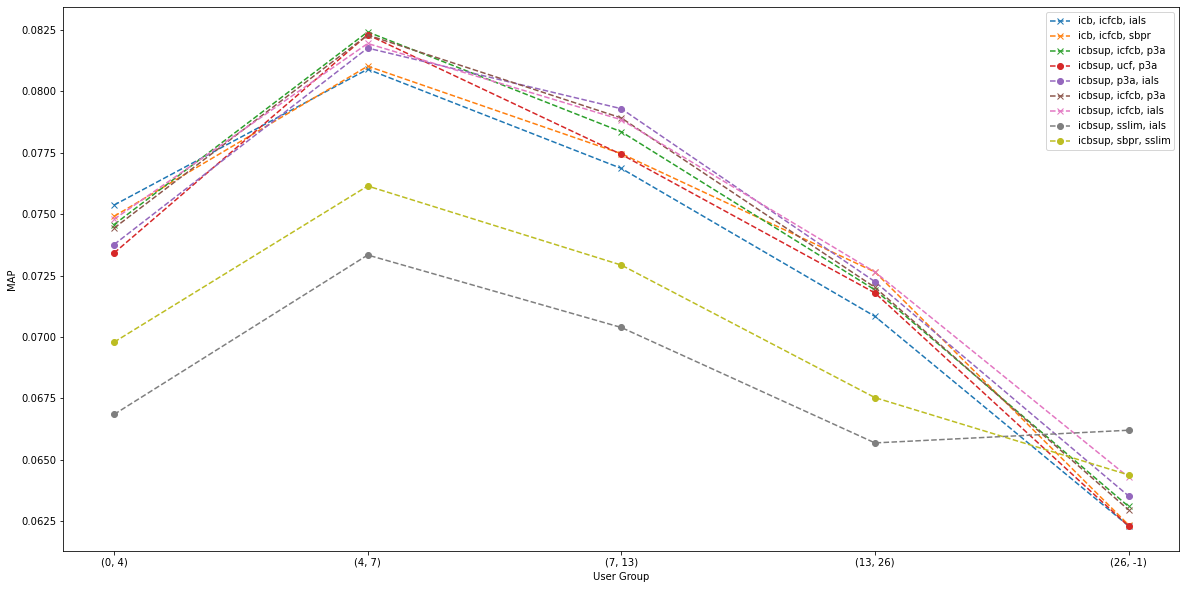

In [15]:
import matplotlib.pyplot as pyplot
%matplotlib inline  
pyplot.figure(figsize=(20,10))
for key in to_be_plotted:
    l=[]
    for result_dict in MAP_per_group:
        l.append(result_dict[key])
    if np.random.random() > 0.5:
        style = '--o'
    else:
        style = '--x'
    label = recommenders[key][0]
    """
    else:
        for merged_dict in MAP_merged_per_group:
            l.append(merged_dict[key])
        style = '--x'
        label = merged_labels[key]
        """
    pyplot.plot(l, style, label = label)

pyplot.xticks(ticks=range(0,len(f_ranges)), labels=f_ranges)
pyplot.ylabel('MAP')
pyplot.xlabel('User Group')
pyplot.legend()
pyplot.show()

In [18]:
to_be_plotted_icm = []
for i in range(0, len (f_ranges)):
    print(f"RANGE {f_ranges[i]}")
    maxp = 0
    old_maxp = 0
    difference = 0
    old_name = ''
    max_name=''
    max_key=None
    old_key=None
    
    result_dict = MAP_per_group[i]
    for key, value in result_dict.items():
        #value = combo_dict.get(key)
        if key >= 56:
            print(f"> MAP {recommenders[key][1]}-{recommenders[key][0]}:\t {value}")
            if value > maxp:
                difference=value - maxp
                old_maxp=maxp
                maxp=value
                old_name=max_name
                max_name=recommenders[key][0]
                old_key=max_key
                max_key=key
            elif value > old_maxp:
                difference=maxp - value
                old_maxp=value
                old_name=recommenders[key][0]
                old_key=key
           
    if max_key not in to_be_plotted_icm:
        to_be_plotted_icm.append(max_key)
    
    if old_key not in to_be_plotted_icm:
        to_be_plotted_icm.append(old_key)
    
    print(f"Max MAP is {maxp} from {max_name}({recommenders[max_key][1]}) with difference from previous max of {difference} from {old_name}({recommenders[old_key][1]}) \n")
        

RANGE (0, 4)
> MAP linear-icbsup, icmrp3b, ials:	 0.07722478625604387
> MAP linear-icfcb, icmrp3b, ials:	 0.07729660743972341
> MAP linear-icbsup, icmicf, ials:	 0.07605280385527952
> MAP linear-icbsup, icmp3a, ials:	 0.07717349966398854
> MAP linear-icbsup, icmrp3b, ucf:	 0.07179887843686614
> MAP linear-icbsup, icmrp3b, sbpr:	 0.07448985132919676
> MAP linear-icfcb, icmrp3b, sbpr:	 0.07488959382413041
> MAP linear-icfcb, icmrp3b, ucf:	 0.07499931130622757
> MAP linear-icbsup, icmicf, sbpr:	 0.073393959618586
> MAP linear-icbsup, sslim, icmrp3b:	 0.07387243583682546
> MAP linear-icfcb, sslim, icmrp3b:	 0.07304984845189333
> MAP linear-icfcb, icmrp3b, icmicf:	 0.07411113879472075
> MAP linear-icbsup, icmrp3b, icmicf:	 0.07385649856393176
> MAP linear-icbsup, icfcb, icmrp3b:	 0.07366267403017317
> MAP linear-icfcb, icmp3a, ials:	 0.07486680502928007
> MAP linear-icbsup, icmicf, ucf:	 0.07413649880719943
Max MAP is 0.07729660743972341 from icfcb, icmrp3b, ials(linear) with difference fro

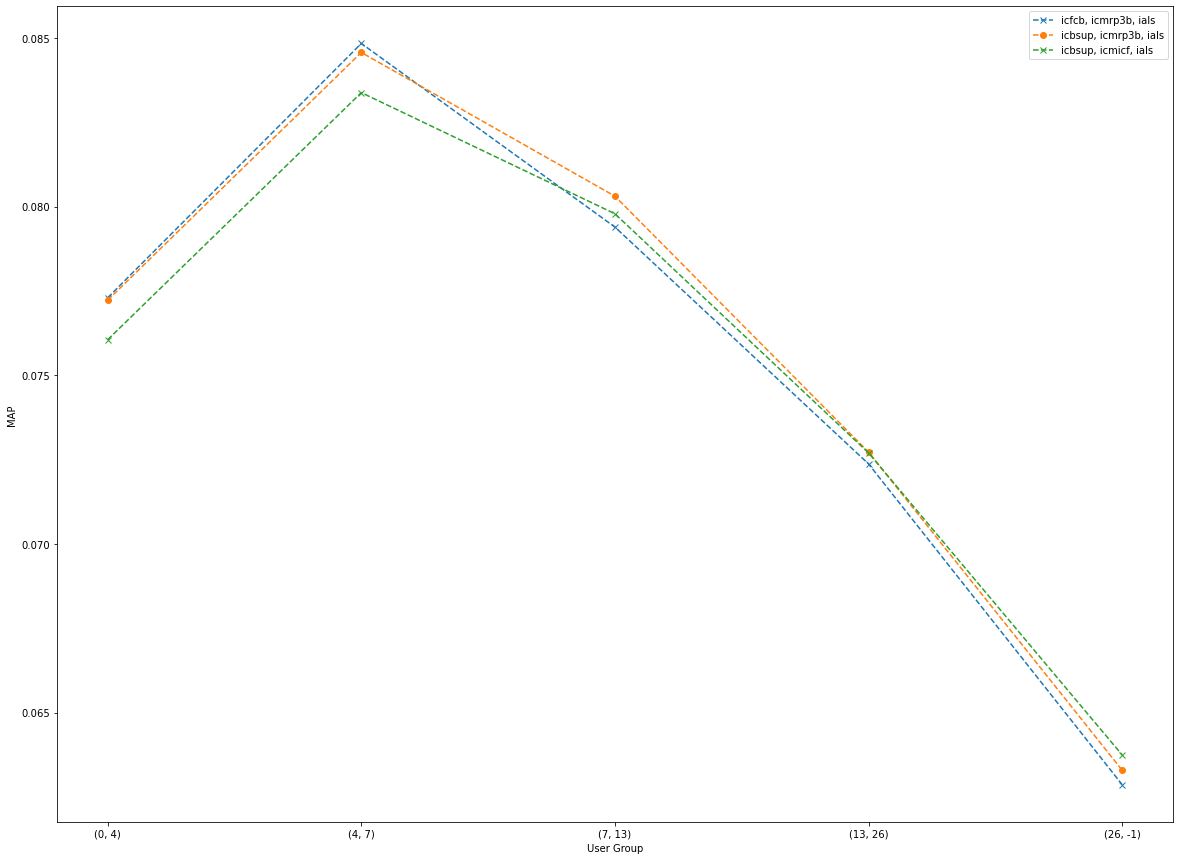

In [19]:
import matplotlib.pyplot as pyplot
%matplotlib inline  
pyplot.figure(figsize=(20,15))
for key in to_be_plotted_icm:
    l=[]
    for result_dict in MAP_per_group:
        l.append(result_dict[key])
    if np.random.random() > 0.5:
        style = '--o'
    else:
        style = '--x'
    label = recommenders[key][0]
    """
    else:
        for merged_dict in MAP_merged_per_group:
            l.append(merged_dict[key])
        style = '--x'
        label = merged_labels[key]
        """
    pyplot.plot(l, style, label = label)

pyplot.xticks(ticks=range(0,len(f_ranges)), labels=f_ranges)
pyplot.ylabel('MAP')
pyplot.xlabel('User Group')
pyplot.legend()
pyplot.show()

In [ ]:
f_ranges = [
    (0,3),
    (3,6),
    (6,11),
    (11,22),
    (22,-1)
]

MAP_per_group = []
cutoff = 10

for f_range in f_ranges:
    
    result_dict={}
    for k in range (num_rec):
        r = []
        for i in range (len(URM_list)):
            URM_test_group = parser.filter_URM_test_by_range(URM_list[i], URM_test_list[i], f_range)
            evaluator_test = EvaluatorHoldout(URM_test_group, cutoff_list=[cutoff])
            
            if recommenders[k][1] == 'single':
                rec = recommenders[k][2][0]
                try:
                    rec = rec(URM_list[i], ICM_all, verbose = False)
                except:
                    rec = rec(URM_list[i], verbose=False)
                try:
                    rec.load_model(f'stored_recommenders/seed_{str(seed)}_hybrid_search/{rec.RECOMMENDER_NAME}/', f'{str(seed)}_fold-{str(i)}')
                    print(f"{rec.RECOMMENDER_NAME} loaded. [seed={seed}, fold={i}]")
                except:
                    print(f"Fitting {rec.RECOMMENDER_NAME} ... [seed={seed}, fold={i}]")
                    rec.fit(**recommenders[k][2][1])
                    print(f"done.")
                    rec.save_model(f'stored_recommenders/seed_{str(seed)}_hybrid_search/{rec.RECOMMENDER_NAME}/', f'{str(seed)}_fold-{str(i)}')
            elif recommenders[k][1] == 'linear':
                rec = HybridCombinationSearchCV2(URM_list[i], ICM_all, recommenders[k][2], seed = seed, fold = i)
                rec.fit(**recommenders[k][3])
            elif recommenders[k][1] == 'merged':
                rec = HybridCombinationMergedSearchCV(URM_list[i], ICM_all, recommenders[k][2], seed = seed, fold = i)
                rec.fit(**recommenders[k][3])
            else:
                raise NameError

            results, _ = evaluator_test.evaluateRecommender(rec)
            r.append(results[cutoff]["MAP"])
        result_dict[k]=np.average(r)

    MAP_per_group.append(result_dict)

ItemKNNCBFRecommender loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1144 ( 100.00% ) in 0.65 sec. Users per second: 1773
ItemKNNCBFRecommender loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1069 ( 100.00% ) in 0.58 sec. Users per second: 1834
ItemKNNCBFRecommender loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1132 ( 100.00% ) in 0.63 sec. Users per second: 1799
ItemKNNCBFRecommender loaded. [seed=1666, fold=3]
EvaluatorHoldout: Processed 1091 ( 100.00% ) in 0.61 sec. Users per second: 1790
ItemKNNCBFRecommender loaded. [seed=1666, fold=4]
EvaluatorHoldout: Processed 1059 ( 100.00% ) in 0.58 sec. Users per second: 1820
Special-ItemKNNCBFRec loaded. [seed=1666, fold=0]
EvaluatorHoldout: Processed 1144 ( 100.00% ) in 0.67 sec. Users per second: 1716
Special-ItemKNNCBFRec loaded. [seed=1666, fold=1]
EvaluatorHoldout: Processed 1069 ( 100.00% ) in 0.68 sec. Users per second: 1582
Special-ItemKNNCBFRec loaded. [seed=1666, fold=2]
EvaluatorHoldout: Processed 1132 

In [ ]:
to_be_plotted = []
for i in range(0, len (f_ranges)):
    print(f"RANGE {f_ranges[i]}")
    maxp = 0
    old_maxp = 0
    difference = 0
    old_name = ''
    max_name=''
    max_key=None
    old_key=None
    
    result_dict = MAP_per_group[i]
    for key, value in result_dict.items():
        #value = combo_dict.get(key)
        if key < 56:
            print(f"> MAP {recommenders[key][1]}-{recommenders[key][0]}:\t {value}")
            if value > maxp:
                difference=value - maxp
                old_maxp=maxp
                maxp=value
                old_name=max_name
                max_name=recommenders[key][0]
                old_key=max_key
                max_key=key
            elif value > old_maxp:
                difference=maxp - value
                old_maxp=value
                old_name=recommenders[key][0]
                old_key=key
           
    if max_key not in to_be_plotted:
        to_be_plotted.append(max_key)
    
    if old_key not in to_be_plotted:
        to_be_plotted.append(old_key)
    
    print(f"Max MAP is {maxp} from {max_name}({recommenders[max_key][1]}) with difference from previous max of {difference} from {old_name}({recommenders[old_key][1]}) \n")
        

In [ ]:
import matplotlib.pyplot as pyplot
%matplotlib inline  
pyplot.figure(figsize=(20,10))
for key in to_be_plotted:
    l=[]
    for result_dict in MAP_per_group:
        l.append(result_dict[key])
    if np.random.random() > 0.5:
        style = '--o'
    else:
        style = '--x'
    label = recommenders[key][0]
    """
    else:
        for merged_dict in MAP_merged_per_group:
            l.append(merged_dict[key])
        style = '--x'
        label = merged_labels[key]
        """
    pyplot.plot(l, style, label = label)

pyplot.xticks(ticks=range(0,len(f_ranges)), labels=f_ranges)
pyplot.ylabel('MAP')
pyplot.xlabel('User Group')
pyplot.legend()
pyplot.show()